In [28]:
from __future__ import print_function

import argparse
import os
import shutil
import time
import copy

import sys
sys.path.append("/ws/external")

# from models.cifar.allconv import AllConvNet
import numpy as np
from third_party.ResNeXt_DenseNet.models.densenet import densenet
from third_party.ResNeXt_DenseNet.models.resnext import resnext29
from third_party.WideResNet_pytorch.wideresnet import WideResNet
from third_party.WideResNet_pytorch.wideresnetproj import WideResNetProj
from third_party.WideResNet_pytorch.wideresnet_encoder import WideResNetEncoder
from third_party.supervised_contrastive_net import SupConNet
from models import MyDataParallel

import torch
import torch.backends.cudnn as cudnn
from torchvision import datasets
from torchvision import transforms
import torch.nn.functional as F

from datasets import *
from datasets.mixdataset import BaseDataset, AugMixDataset
from torch.utils.data import Dataset

from feature_hook import FeatureHook
from utils import WandbLogger
# from apis import test, test_c, test_c_dg, Trainer

from collections import defaultdict
import pandas as pd

### Set argument

In [29]:
class Args():
    def __init__(self):
        self.dataset = 'cifar10'
        self.num_classes=10
        
        self.aug = 'augmix'
        self.model = 'wrn'
        self.epochs = 5
        self.batch_size = 8
        self.eval_batch_size = 10
        
        self.no_jsd = False
        self.additional_loss = 'jsd'
        self.temper = 1.0
        self.lambda_weight = 12.0
                
        # '/ws/data/log/cifar10/augmix_b512/checkpoint.pth.tar' # None '/ws/data/log/cifar10/augmix_b512/checkpoint.pth.tar'
        self.resume = "/ws/data/log/cifar10/baselines/pixmix_b256_jsd/model_best.pth.tar" # "/ws/data/log/cifar10/baselines/augmix_b256_jsdv3_lw12/model_best.pth.tar" # "/ws/data/log/cifar10/baselines/pixmix_b512_jsdv3_lw12/checkpoint.pth.tar" #  # '/ws/data/log/cifar10/baselines/augmix_b512/checkpoint.pth.tar' # '/ws/data/log/cifar10/baseline_b512/checkpoint.pth.tar' # None # '/ws/data/log/cifar10/baselines/augmix_b512/checkpoint.pth.tar' # '/ws/data/log/cifar10/baseline_b512/checkpoint.pth.tar'
        self.evaluate = False
        self.analysis = True
        self.confusion_matrix = False
        self.save = '/ws/data/log/cifar10/augmix_b512' # None
        self.base_path = "/ws/data/cifar/CIFAR-10-C/"
        
        self.learning_rate = 0.001
        self.momentum = 0.9
        self.decay = 0.0005
        self.layers = 40
        self.widen_factor = 2
        self.droprate = 0.0
        self.mixture_width = 3
        self.mixture_depth = -1
        self.aug_severity = 3
        self.mixture_coefficient = 1.0
        
        self.reduction = 'batchmean'
        self.all_ops = 'all'
        self.num_workers = 0
        self.wandb_logger = None
        self.wandb = False
        
def get_lr(step, total_steps, lr_max, lr_min):
    """Compute learning rate according to cosine annealing schedule."""
    return lr_min + (lr_max - lr_min) * 0.5 * (1 +
                                               np.cos(step / total_steps * np.pi))

CORRUPTIONS = [
  'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
  'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
  'brightness', 'contrast', 'elastic_transform', 'pixelate',
  'jpeg_compression'
]

In [30]:
args = Args()

In [31]:
''' Load datasets '''
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4)])
preprocess = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5] * 3, [0.5] * 3)])
test_transform = preprocess

train_dataset = datasets.CIFAR10(
            '/ws/data/cifar', train=True, transform=train_transform, download=True)
test_dataset = datasets.CIFAR10(
    '/ws/data/cifar', train=False, transform=test_transform, download=True)
mixed_test_dataset = datasets.CIFAR10(
    '/ws/data/cifar', train=False, transform=None, download=True)
base_c_path = '/ws/data/cifar/CIFAR-10-C/'

train_dataset = AugMixDataset(train_dataset, preprocess, args.no_jsd,
                           args.all_ops, args.mixture_width, args.mixture_depth, args.aug_severity, args.mixture_coefficient)


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=args.num_workers,
    pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=args.eval_batch_size,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [32]:
class ConcatDataset(Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets[0]

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

In [33]:
net = WideResNet(args.layers, args.num_classes, args.widen_factor, args.droprate)
net = MyDataParallel(net).cuda()
cudnn.benchmark = True
optimizer = torch.optim.SGD(
    net.parameters(),
    args.learning_rate,
    momentum=args.momentum,
    weight_decay=args.decay,
    nesterov=True)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, \
                                              lr_lambda=lambda step: get_lr(step, args.epochs * len(train_loader), 1,  1e-6 / args.learning_rate))  

if args.resume:
    if os.path.isfile(args.resume):
        checkpoint = torch.load(args.resume)
        start_epoch = checkpoint['epoch'] + 1
        best_acc = checkpoint['best_acc']
        net.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print('Model restored from epoch:', start_epoch)

Model restored from epoch: 96


In [34]:
def analysisv1_0(logits_clean, logits_aug1, logits_aug2=None, lambda_weight=12):

    B, C = logits_clean.size()
    
    if logits_aug2 == None:
        p_clean, p_aug1, = F.softmax(logits_clean, dim=1),\
                           F.softmax(logits_aug1, dim=1)

        # Clamp mixture distribution to avoid exploding KL divergence
        # jsd: batchmean reduction
        p_mixture = torch.clamp((p_clean + p_aug1) / 2., 1e-7, 1).log()
        jsd = (F.kl_div(p_mixture, p_clean, reduction='batchmean') + F.kl_div(p_mixture, p_aug1, reduction='batchmean')) / 2.
        jsd_mean = (F.kl_div(p_mixture, p_clean, reduction='mean') + F.kl_div(p_mixture, p_aug1, reduction='mean')) / 2.

#         # mse: mean reduction
#         mse = (F.mse_loss(logits_clean, logits_aug1, reduction='mean')) / B

#         # cosine_similarity: mean reduction
#         similarity = F.cosine_similarity(logits_clean, logits_aug1)
#         similarity = similarity.mean()
        features = {'jsd_batchmean': jsd,
    #                 'mse': mse,
    #                 'similarity': similarity,
                    'p_clean': p_clean,
                    'p_aug1': p_aug1,
                    'p_mixture': p_mixture,
                    }
    else:
        p_clean, p_aug1, p_aug2 = F.softmax(logits_clean, dim=1),\
                              F.softmax(logits_aug1, dim=1), \
                            F.softmax(logits_aug2, dim=1)

        # Clamp mixture distribution to avoid exploding KL divergence
        p_mixture = torch.clamp((p_clean + p_aug1 + p_aug2) / 3., 1e-7, 1).log()
        jsd = (F.kl_div(p_mixture, p_clean, reduction='batchmean') +
                        F.kl_div(p_mixture, p_aug1, reduction='batchmean') +
                        F.kl_div(p_mixture, p_aug2, reduction='batchmean')) / 3.
#         similarity = (F.cosine_similarity(logits_clean, logits_aug1) +
#                   F.cosine_similarity(logits_clean, logits_aug2) +
#                   F.cosine_similarity(logits_aug1, logits_aug2)) / 3
#         similarity = similarity.mean()


        features = {'jsd_batchmean': jsd,
    #                 'mse': mse,
    #                 'similarity': similarity,
                    'p_clean': p_clean,
                    'p_aug1': p_aug1,
                    'p_aug2': p_aug2,
                    'p_mixture': p_mixture,
                    }
    loss = jsd

    return loss, features

In [35]:
base_path = args.base_path

# load clean,npy

# test_c_features, test_c_mean_features = dict(), defaultdict(float)
# wandb_table = pd.DataFrame(columns=CORRUPTIONS, index=['loss', 'error'])
# confusion_matrices = []
import copy
original_test_dataset = copy.deepcopy(test_dataset)
original_test_dataset.data = np.load(base_path + 'clean' + '.npy')
original_test_dataset.targets = torch.LongTensor(np.load(base_path + 'labels.npy'))

# load augmixed npy
# mixed_test_dataset = copy.deepcopy(mixed_test_dataset)
mixed_test_dataset = datasets.CIFAR10('/ws/data/cifar', train=False, transform=None, download=True)
mixed_test_dataset.data = np.load(base_path + 'clean' + '.npy')
mixed_test_dataset.targets = torch.LongTensor(np.load(base_path + 'labels.npy'))
mixed_test_dataset = AugMixDataset(mixed_test_dataset, preprocess, True,
                                   args.all_ops, args.mixture_width, args.mixture_depth, args.aug_severity, 
                                   args.mixture_coefficient)


# load corruption npy
#corruption_accs = []
#        for corruption in CORRUPTIONS:

corruption = 'gaussian_noise'
corrupted_test_dataset = copy.deepcopy(test_dataset)
corrupted_test_dataset.data = np.load(base_path + corruption + '.npy')
corrupted_test_dataset.targets = torch.LongTensor(np.load(base_path + 'labels.npy'))


# concatenate datasets
concat_dataset = ConcatDataset((original_test_dataset, 
                                mixed_test_dataset, 
                                corrupted_test_dataset))
test_loader = torch.utils.data.DataLoader(
    concat_dataset,
    batch_size=args.eval_batch_size,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=True)

Files already downloaded and verified


In [36]:
# hook
from feature_hook import FeatureHook


layer_list = []
for key, value in net.named_modules():
    layer_list.append(key)


hook = FeatureHook(layer_list)
hook.hook_multi_layer(net)

In [37]:
net.eval()
total_loss, total_correct = 0., 0.
wandb_features = dict()
confusion_matrix = torch.zeros(10, 10)
tsne_features = []
device = 'cuda'

In [38]:
with torch.no_grad():
    for i, (clean_data, mixed_data, corrupted_data) in enumerate(test_loader):
        if i == 50000 / args.eval_batch_size -2: 
            print('i: ', i)
            clean_images, _ = clean_data
            mixed_images, _ = mixed_data
            corrupted_images, targets = corrupted_data
            images_all = torch.cat([clean_images, mixed_images, corrupted_images], 0).to(device)
            # targets_all = torch.cat([targets, targets], 0).to(self.device)
            targets = targets.to(device)

            logits_all = net(images_all)
            logits, logits_mixed, logits_corrupted = torch.chunk(logits_all, 3)
            additional_loss, feature = analysisv1_0(logits, logits_mixed, logits_corrupted, lambda_weight=12)

            loss = F.cross_entropy(logits, targets)
            loss_mixed = F.cross_entropy(logits_mixed, targets)
            loss_corrupted = F.cross_entropy(logits_corrupted, targets)
            pred = logits.data.max(1)[1]
            pred_mixed = logits_mixed.data.max(1)[1]
            pred_corrupted = logits_corrupted.data.max(1)[1]
            correct = pred.eq(targets.data).sum().item()
            correct_mixed = pred_mixed.eq(targets.data).sum().item()
            correct_corrupted = pred_corrupted.eq(targets.data).sum().item()
            break



#     total_loss += float(loss.data)
#     total_correct += pred.eq(targets.data).sum().item()
    

i:  4998


In [39]:
feature.keys()
# max value plot
# false case plot
# plot at the same time

dict_keys(['jsd_batchmean', 'p_clean', 'p_aug1', 'p_aug2', 'p_mixture'])

In [40]:
import matplotlib.pyplot as plt
def plot_images(images, batch_size=8):
    images = images.detach().cpu().numpy()
    images = images.transpose(0, 2, 3, 1)

    fig = plt.figure(figsize=(8, batch_size))
    for i in range(0, batch_size):
        fig.add_subplot(1, batch_size, i+1)
        plt.imshow(images[i])
    plt.axis('off')
    plt.show()

In [41]:
logits.max(1)[0]

tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

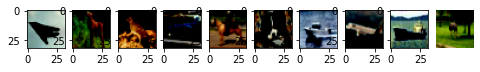

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')



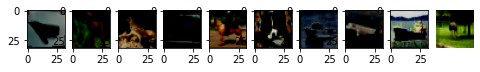

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred_mixed: tensor([0, 4, 6, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits_mixed: tensor([3.5327, 3.1831, 2.1090, 2.5638, 3.9037, 2.6491, 3.1465, 3.3744, 3.9107,
        2.1260], device='cuda:0')
correct_mixed: tensor([ True,  True, False,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


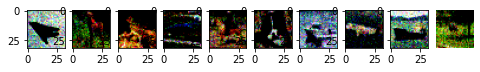

pred_corrupted: tensor([0, 4, 2, 0, 7, 3, 8, 0, 8, 4], device='cuda:0')

logits_corrupted: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
correct_corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')



In [42]:
print(f"target: {targets}\n",)
print("class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck \n")
plot_images(clean_images, batch_size=args.eval_batch_size)
print(f"pred: {pred}\n")
print(f"logits: {logits.max(1)[0]}")
correct = pred.eq(targets.data)
print(f"correct: {correct}\n")

plot_images(mixed_images, batch_size=args.eval_batch_size)
print(f"pred_mixed: {pred_mixed}\n")
print(f"logits_mixed: {logits_mixed.max(1)[0]}")
correct_mixed = pred_mixed.eq(targets.data)
print(f"correct_mixed: {correct_mixed}\n")

plot_images(corrupted_images, batch_size=args.eval_batch_size)
print(f"pred_corrupted: {pred_corrupted}\n")
print(f"logits_corrupted: {logits_corrupted.max(1)[0]}")
correct_corrupted = pred_corrupted.eq(targets.data)
print(f"correct_corrupted: {correct_corrupted}\n")


### plot feature matrix

In [43]:
fc_features = net.module.hook_features['module.fc']
fc_clean, fc_mixed, fc_corrupted = torch.chunk(fc_features[0], 3)

avgpool_features = net.module.hook_features['module.avgpool']
avgpool_features[0] = avgpool_features[0].squeeze()
avgpool_clean, avgpool_mixed, avgpool_corrupted = torch.chunk(avgpool_features[0], 3)

In [44]:
def plot_features_matrix(cm,
                          classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
                          normalize=False,
                          title='Confusion matrix',
                          text=True,
                          cmap=plt.cm.Blues,
                        save=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
        # print('Confusion matrix, without normalization')
        pass

    # print(cm)
    # print(cm.diag() / cm.sum(1))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)
    
    if text:
        fmt = '.2f' if normalize else '.2f' #'d'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], fmt),
                         horizontalalignment="center",
                         fontsize=10,
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Batch')
    plt.xlabel('Channel')
    # wandb.log({title: plt})
    if save:
        plt.savefig(f'/ws/data/log/cifar10/visualizations/{title}')
    
    return plt

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')



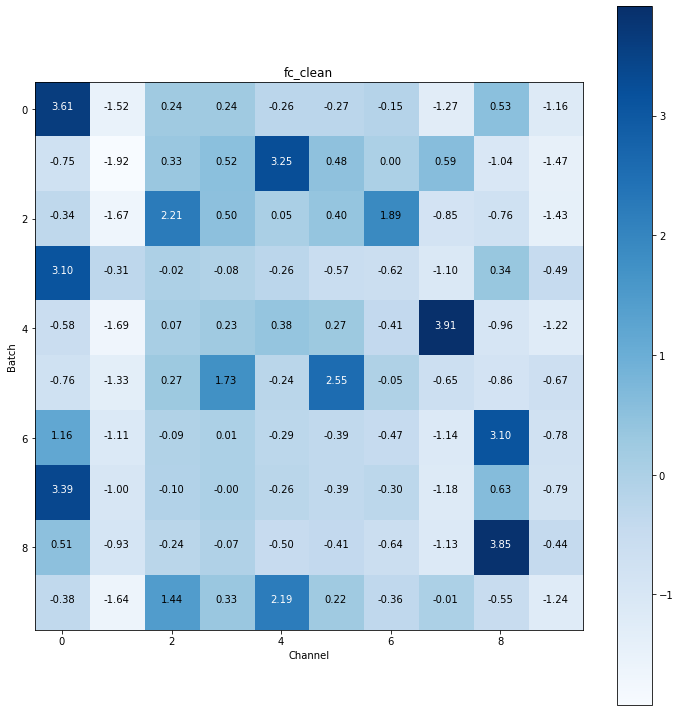

In [48]:
plot_features_matrix(fc_clean.detach().cpu().numpy(), title='fc_clean', save=True)
print(f"target: {targets}\n",)
print("class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck \n")
print(f"pred: {pred}\n")
correct = pred.eq(targets.data)
print(f"correct: {correct}\n")

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

pred_corrupted: tensor([0, 4, 2, 0, 7, 3, 8, 0, 8, 4], device='cuda:0')

correct_corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')



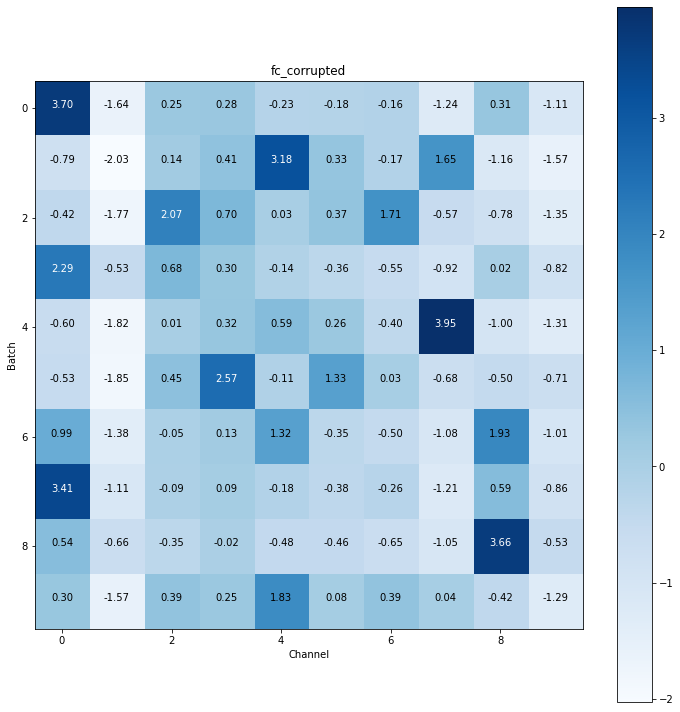

In [47]:
plot_features_matrix(fc_corrupted.detach().cpu().numpy(), title='fc_corrupted', save=True)
print(f"target: {targets}\n",)
print("class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck \n")
print(f"pred: {pred}\n")
print(f"pred_corrupted: {pred_corrupted}\n")
correct_corrupted = pred_corrupted.eq(targets.data)
print(f"correct_corrupted: {correct_corrupted}\n")

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

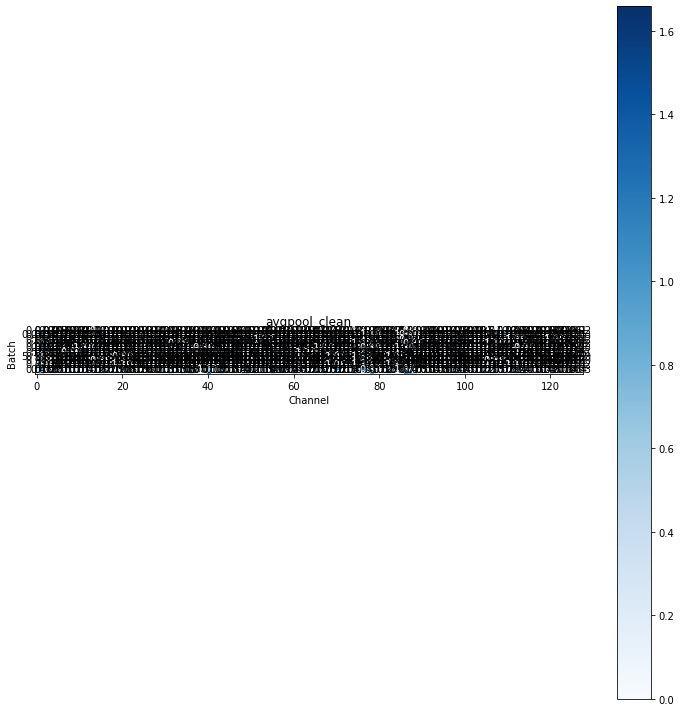

In [49]:
plot_features_matrix(avgpool_clean.detach().cpu().numpy(), text=True, title='avgpool_clean', save=True)

In [ ]:
plot_features_matrix(avgpool_corrupted.detach().cpu().numpy(), text=False, title='Logits')

### plot scattter3d 

X_shape:  (10, 10)
Y_shape:  (10, 10)
Z_shape:  (10, 10)
correct:  tensor([False, False, False, False, False, False,  True, False,  True, False],
       device='cuda:0')
correct_mixed:  tensor([False, False, False, False, False, False,  True, False,  True, False],
       device='cuda:0')
correct_corrupted:  tensor([False, False, False, False, False, False,  True, False,  True, False],
       device='cuda:0')


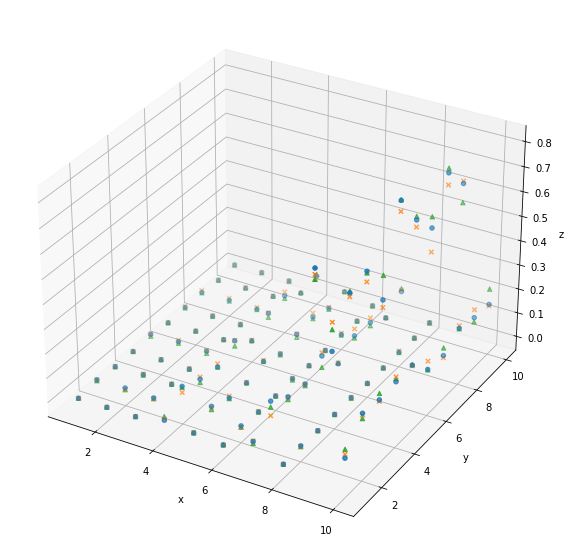

In [197]:
## plot scattter3d all value## 

x1 = np.linspace(1, 10, 10)
y1 = np.linspace(1, args.eval_batch_size, args.eval_batch_size)
z1 = feature['p_clean'].detach().cpu().numpy()
X1, Y1 = np.meshgrid(x1, y1)
Z1 = feature['p_clean'].detach().cpu().numpy()
# Z1 = feature['p_clean'][pred_correct].detach().cpu().numpy()

print('X_shape: ', np.shape(X1))
print('Y_shape: ', np.shape(Y1))
print('Z_shape: ', np.shape(Z1))
# print('z1: ', z1)

x2 = np.linspace(1, 10, 10)
y2 = np.linspace(1, args.eval_batch_size, args.eval_batch_size)
z2 = feature['p_aug1'].detach().cpu().numpy()
X2, Y2 = np.meshgrid(x2, y2)
Z2 = feature['p_aug1'].detach().cpu().numpy()

x3 = np.linspace(1, 10, 10)
y3 = np.linspace(1, args.eval_batch_size, args.eval_batch_size)
z3 = feature['p_aug2'].detach().cpu().numpy()
X3, Y3 = np.meshgrid(x3, y3)
Z3 = feature['p_aug2'].detach().cpu().numpy()


fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(X1, Y1, Z1, marker='o')
ax.scatter(X2, Y2, Z2, marker='x')
ax.scatter(X3, Y3, Z3, marker='^')


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

print('correct: ', correct)
print('correct_mixed: ', correct_mixed)
print('correct_corrupted: ', correct_corrupted)

In [126]:
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
import math
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


def polygon_under_graph(x, y):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """
    return [(x[0], 0.), *zip(x, y), (x[-1], 0.)]



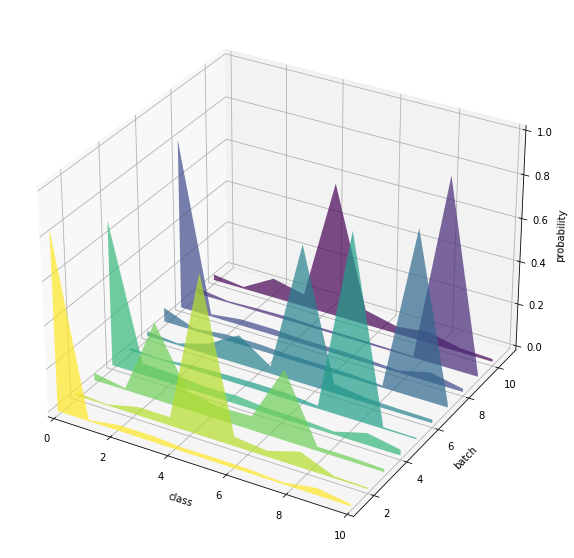

In [127]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')

x = np.linspace(0., 10., 10)
Z1 = feature['p_clean'].detach().cpu().numpy()
# B, C = np.shape(Z1)
# print(f'B: {B}, C: {C}')
k = polygon_under_graph(x, Z1[0])
# print("k: ", np.shape(k))
verts = [polygon_under_graph(x, l) for l in Z1]
# print("verts: ", np.shape(verts))

facecolors = plt.colormaps['viridis_r'](np.linspace(0, 1, len(verts)))
poly = PolyCollection(verts, facecolors=facecolors, alpha=.7)
ax.add_collection3d(poly, zs=range(1, 11), zdir='y')

ax.set(xlim=(0, 10), ylim=(1, 11), zlim=(0, 1.0),
       xlabel='class', ylabel='batch', zlabel='probability');


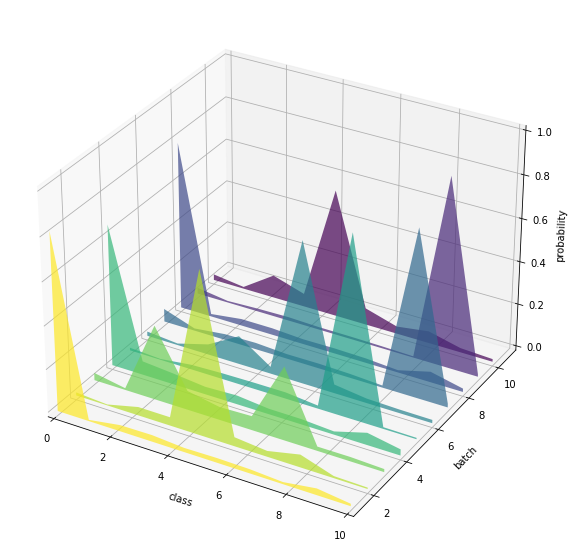

In [128]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')

Z2 = feature['p_aug1'].detach().cpu().numpy()
x = np.linspace(0., 10., 10)
verts = [polygon_under_graph(x, l) for l in Z2]

facecolors = plt.colormaps['viridis_r'](np.linspace(0, 1, len(verts)))
poly = PolyCollection(verts, facecolors=facecolors, alpha=.7)
ax.add_collection3d(poly, zs=range(1, 11), zdir='y')

ax.set(xlim=(0, 10), ylim=(1, 11), zlim=(0, 1.0),
       xlabel='class', ylabel='batch', zlabel='probability');

plt.show()

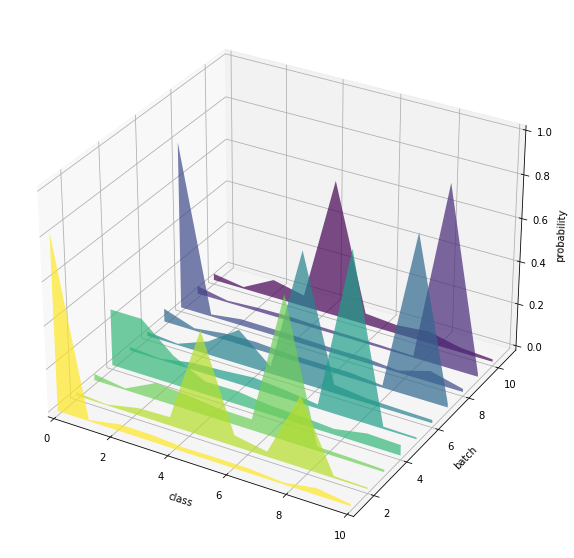

In [129]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')

Z2 = feature['p_aug2'].detach().cpu().numpy()
x = np.linspace(0., 10., 10)
verts = [polygon_under_graph(x, l) for l in Z2]

facecolors = plt.colormaps['viridis_r'](np.linspace(0, 1, len(verts)))
poly = PolyCollection(verts, facecolors=facecolors, alpha=.7)
ax.add_collection3d(poly, zs=range(1, 11), zdir='y')

ax.set(xlim=(0, 10), ylim=(1, 11), zlim=(0, 1.0),
       xlabel='class', ylabel='batch', zlabel='probability');

plt.show()